# 21.4 R-Learner Introduction

**Chapter**: 21 - Meta-Learners  
**Section**: 4 - R-Learner and Bridge to Double ML  
**Facure Source**: 21-Meta-Learners.ipynb, 22-Debiased-Orthogonal-Machine-Learning.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Limitations of S/T/X Learners](#1-limitations-of-stx-learners)
2. [The Robinson Transformation](#2-the-robinson-transformation)
3. [R-Learner: Residual-on-Residual](#3-r-learner-residual-on-residual)
4. [Connection to Double ML](#4-connection-to-double-ml)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

set_notebook_style()
np.random.seed(42)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition: Limitations of S/T/X Learners

> **Recall from previous notebooks**:
> - S-learner: Regularization bias (shrinks toward zero)
> - T-learner: Sample imbalance creates spurious heterogeneity
> - X-learner: Better, but still susceptible to model misspecification

**Common thread**: All learners estimate $E[Y|X,T]$ directly, which couples:
- The outcome model (nuisance)
- The treatment effect (target)

**The R-Learner takes a different approach**: Use **residuals** to separate the causal signal from confounding.

---

## 2. Formal Treatment: The Robinson Transformation

The R-learner is based on **Robinson's (1988) partial linear model**:

$$Y = \tau(X) \cdot T + g(X) + \varepsilon$$

where:
- $\tau(X)$: The CATE we want to estimate
- $g(X)$: Direct effect of confounders on outcome (nuisance)
- $\varepsilon$: Noise

And treatment follows:
$$T = m(X) + v$$

where $m(X) = E[T|X]$ (propensity).

### The Key Insight

Take expectations conditional on X:
$$E[Y|X] = \tau(X) \cdot E[T|X] + g(X) = \tau(X) \cdot m(X) + g(X)$$

Subtract from the original equation:
$$Y - E[Y|X] = \tau(X) \cdot (T - E[T|X]) + \varepsilon$$

Or more compactly:
$$\tilde{Y} = \tau(X) \cdot \tilde{T} + \varepsilon$$

**The nuisance function $g(X)$ cancels out!**

In [2]:
# Generate data with known CATE function
np.random.seed(42)

n = 2000
X = np.random.uniform(0, 1, (n, 2))

# Propensity: m(X) = P(T=1|X) depends on X
propensity = 0.3 + 0.4 * X[:, 0]  # Linear in X0
T = np.random.binomial(1, propensity)

# True CATE: tau(X) = 1 + 2*X0 (heterogeneous!)
true_tau = 1 + 2 * X[:, 0]

# Outcome: Y = tau(X)*T + g(X) + noise
# where g(X) = sin(2*pi*X0) + X1^2 (complex nuisance)
g_x = np.sin(2 * np.pi * X[:, 0]) + X[:, 1]**2
Y = true_tau * T + g_x + np.random.normal(0, 0.3, n)

print(f"Generated {n} samples")
print(f"True CATE range: [{true_tau.min():.2f}, {true_tau.max():.2f}]")
print(f"Treatment rate: {T.mean():.1%}")

Generated 2000 samples
True CATE range: [1.00, 3.00]
Treatment rate: 51.3%


---

## 3. Numeric Demonstration: R-Learner

The R-learner (Nie & Wager, 2021) operationalizes Robinson's insight:

### Algorithm

1. **Estimate nuisance functions** (using cross-fitting):
   - $\hat{m}(X) \approx E[T|X]$ (propensity)
   - $\hat{\ell}(X) \approx E[Y|X]$ (reduced form outcome)

2. **Compute residuals**:
   - $\tilde{T}_i = T_i - \hat{m}(X_i)$
   - $\tilde{Y}_i = Y_i - \hat{\ell}(X_i)$

3. **Estimate CATE by minimizing R-loss**:
   $$\hat{\tau} = \arg\min_\tau \sum_i \tilde{T}_i^2 \left( \frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i) \right)^2$$

This is weighted least squares of $\tilde{Y}/\tilde{T}$ on X, with weights $\tilde{T}^2$.

```
R-Learner Architecture ──────────────────────────────────────

       [Y, T, X]
          │
    ┌─────┴─────┐
    │           │
    ▼           ▼
  ┌─────┐    ┌─────┐
  │ℓ̂(X)│    │m̂(X) │   ← Nuisance models (cross-fitted)
  └──┬──┘    └──┬──┘
     │          │
     ▼          ▼
   Ỹ = Y-ℓ̂   T̃ = T-m̂  ← Residuals
     │          │
     └────┬─────┘
          │
          ▼
    ┌───────────┐
    │ Minimize  │
    │ R-Loss    │   ← Weighted regression of Ỹ/T̃ on X
    │ for τ(X)  │
    └───────────┘
          │
          ▼
       τ̂(X)
──────────────────────────────────────────────────────────────
```

In [3]:
# Step 1: Estimate nuisance functions with cross-fitting
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Propensity model m(X) = E[T|X]
m_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
m_hat = cross_val_predict(m_model, X, T, cv=5, method='predict_proba')[:, 1]

# Outcome model ℓ(X) = E[Y|X]
l_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
l_hat = cross_val_predict(l_model, X, Y, cv=5)

print("Nuisance models estimated (cross-fitted)")
print(f"Propensity R²: {1 - np.var(T - m_hat) / np.var(T):.3f}")
print(f"Outcome R²:    {1 - np.var(Y - l_hat) / np.var(Y):.3f}")

Nuisance models estimated (cross-fitted)
Propensity R²: 0.044
Outcome R²:    0.143


In [4]:
# Step 2: Compute residuals
T_tilde = T - m_hat  # Treatment residual
Y_tilde = Y - l_hat  # Outcome residual

print(f"Treatment residual: mean={T_tilde.mean():.4f} (should be ~0)")
print(f"Outcome residual:   mean={Y_tilde.mean():.4f} (should be ~0)")

Treatment residual: mean=0.0004 (should be ~0)
Outcome residual:   mean=0.0007 (should be ~0)


In [5]:
# Step 3: Minimize R-loss
# For simplicity, we'll use weighted regression with a flexible model

# Weights = T_tilde^2
weights = T_tilde**2

# Target = Y_tilde / T_tilde (pseudo-outcome)
# Need to handle T_tilde near zero - use regularization
eps = 0.01
pseudo_outcome = Y_tilde / (T_tilde + eps * np.sign(T_tilde))

# Fit weighted regression
tau_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
tau_model.fit(X, pseudo_outcome, sample_weight=weights)

# Predict CATE
cate_r = tau_model.predict(X)

print(f"R-Learner CATE: mean={cate_r.mean():.3f}")
print(f"True CATE:      mean={true_tau.mean():.3f}")

R-Learner CATE: mean=1.943
True CATE:      mean=1.989


In [6]:
# Compare R-learner to other learners
from lightgbm import LGBMRegressor

# S-learner
s_model = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1)
df = pd.DataFrame(X, columns=['X0', 'X1'])
df['T'] = T
s_model.fit(df, Y)
df_t1 = df.copy()
df_t1['T'] = 1
df_t0 = df.copy()
df_t0['T'] = 0
cate_s = s_model.predict(df_t1) - s_model.predict(df_t0)

# T-learner
m0 = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1)
m1 = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1)
m0.fit(X[T==0], Y[T==0])
m1.fit(X[T==1], Y[T==1])
cate_t = m1.predict(X) - m0.predict(X)

# Compute RMSE
rmse_s = np.sqrt(np.mean((cate_s - true_tau)**2))
rmse_t = np.sqrt(np.mean((cate_t - true_tau)**2))
rmse_r = np.sqrt(np.mean((cate_r - true_tau)**2))

print("RMSE Comparison:")
print(f"  S-Learner: {rmse_s:.3f}")
print(f"  T-Learner: {rmse_t:.3f}")
print(f"  R-Learner: {rmse_r:.3f}")

RMSE Comparison:
  S-Learner: 0.129
  T-Learner: 0.152
  R-Learner: 0.133


/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


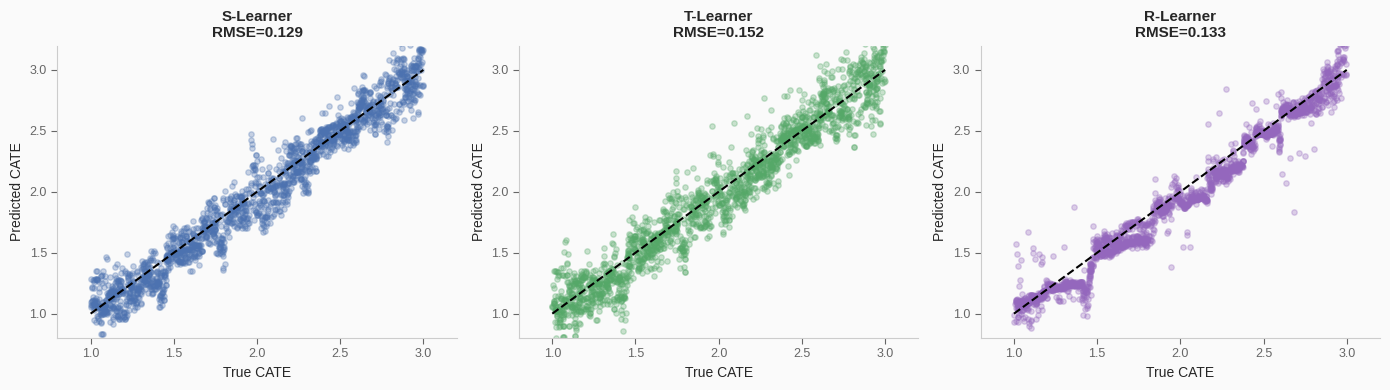

In [7]:
# Visualize
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

for ax, (cate, name, color) in zip(axes, [
    (cate_s, 'S-Learner', COLORS['blue']),
    (cate_t, 'T-Learner', COLORS['green']),
    (cate_r, 'R-Learner', COLORS['purple']),
]):
    ax.scatter(true_tau, cate, alpha=0.3, s=15, c=color)
    ax.plot([1, 3], [1, 3], 'k--', lw=1.5)
    ax.set_xlabel('True CATE')
    ax.set_ylabel('Predicted CATE')
    rmse = np.sqrt(np.mean((cate - true_tau)**2))
    ax.set_title(f'{name}\nRMSE={rmse:.3f}', fontweight='bold')
    ax.set_xlim(0.8, 3.2)
    ax.set_ylim(0.8, 3.2)

plt.tight_layout()
plt.show()

---

## 4. Implementation: Connection to Double ML

The R-learner is closely related to **Double Machine Learning (DML)**:

```
R-Learner ↔ DML Connection ──────────────────────────────────

DML for ATE:
─────────────
1. Cross-fit nuisance: ℓ̂(X), m̂(X)
2. Compute residuals: Ỹ = Y - ℓ̂(X), T̃ = T - m̂(X)
3. Regress Ỹ on T̃ to get τ̂ (a single number)

R-Learner for CATE:
────────────────────
1. Cross-fit nuisance: ℓ̂(X), m̂(X)  [Same!]
2. Compute residuals: Ỹ, T̃           [Same!]
3. Learn τ(X) to minimize R-loss     [CATE instead of ATE]

Key insight:
- DML estimates CONSTANT effect τ
- R-learner estimates FUNCTION τ(X)
- Same orthogonalization principle!
──────────────────────────────────────────────────────────────
```

### Why Orthogonalization Helps

The residualization step creates **Neyman orthogonality**:
- First-order errors in nuisance estimation have zero first-order effect on $\hat{\tau}$
- Enables use of ML methods (which are biased) for nuisance
- See Chapter 22 (Debiased ML) and DML Bridge notebooks for full treatment

In [8]:
# DML estimate of ATE (for comparison)
# This is the constant-effect version of what R-learner does for heterogeneous effects

tau_dml = np.sum(Y_tilde * T_tilde) / np.sum(T_tilde**2)

print(f"DML ATE estimate: {tau_dml:.3f}")
print(f"True mean CATE:   {true_tau.mean():.3f}")
print(f"\nR-learner estimates CATE(x), DML estimates mean(CATE)")

DML ATE estimate: 1.976
True mean CATE:   1.989

R-learner estimates CATE(x), DML estimates mean(CATE)


### R-Learner Advantages

| Aspect | S/T/X Learners | R-Learner |
|--------|----------------|------------|
| Handles continuous T | S only | Yes |
| Robust to nuisance error | No | Yes (orthogonal) |
| Sample splitting | Not required | Cross-fitting recommended |
| Complexity | Lower | Higher |
| When to use | Simple cases | Complex confounding |

```
Meta-Learner Evolution ──────────────────────────────────────

S-Learner → T-Learner → X-Learner → R-Learner
                                         │
                                         ↓
                              Double Machine Learning
                              (Chapter 22)
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Two Sigma, Quant)**: *"What is the R-learner and how does it relate to Double ML?"*

<details>
<summary>Solution</summary>

**R-Learner**:

Based on Robinson (1988) partial linear model: $Y = \tau(X) \cdot T + g(X) + \varepsilon$

**Algorithm**:
1. Estimate nuisance: $\hat{\ell}(X) \approx E[Y|X]$, $\hat{m}(X) \approx E[T|X]$
2. Compute residuals: $\tilde{Y} = Y - \hat{\ell}(X)$, $\tilde{T} = T - \hat{m}(X)$
3. Minimize R-loss: $\sum \tilde{T}^2 (\tilde{Y}/\tilde{T} - \tau(X))^2$

**Relation to DML**:

- DML: Same residualization, but estimates constant $\tau$ (ATE)
- R-learner: Same principle, but learns $\tau(X)$ (CATE function)
- Both use **Neyman orthogonality**: Nuisance errors have second-order effect

**Key equation**: $\tilde{Y} = \tau(X) \cdot \tilde{T} + \varepsilon$

The nuisance $g(X)$ cancels when we subtract conditional expectations!

</details>

---

**Q2 (Meta IC6)**: *"Why does the R-learner handle continuous treatments while T/X learners don't?"*

<details>
<summary>Solution</summary>

**T/X learners require discrete T** because they:
- Split data by treatment level: $D_0 = \{i: T_i = 0\}$, $D_1 = \{i: T_i = 1\}$
- Fit separate models: $\hat{\mu}_0$, $\hat{\mu}_1$
- With continuous T, there's no natural split!

**R-learner works with continuous T** because:
- No splitting by T value
- Uses residualization: $\tilde{T} = T - E[T|X]$
- The partial linear model $Y = \tau(X) \cdot T + g(X) + \varepsilon$ works for any T
- R-loss minimization handles continuous $\tilde{T}$ naturally

**S-learner also handles continuous T** because it doesn't split by T either — it includes T as a feature.

</details>

---

## 6. References

[^1]: Nie, X. and Wager, S. (2021). Quasi-oracle estimation of heterogeneous treatment effects. *Biometrika*, 108(2), 299-319.

[^2]: Robinson, P. M. (1988). Root-N-Consistent Semiparametric Regression. *Econometrica*, 56(4), 931-954.

[^3]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*.

[^4]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapters 21-22.

---

**Next**: [Chapter 22: Debiased ML](../22_debiased_ml/01_dml_intuition.ipynb) — Full DML theory and implementation